### Name   : Ibadullah Hayat
### Reg No : B23F0001AI010
### Section : F23 AI-GREEN

## Lab 11: Unsupervised Learning on Wine Dataset
### K-Means Clustering + Principal Component Analysis (PCA)

### Objective:
Apply K-Means clustering and Principal Component Analysis (PCA) to the Wine dataset to discover hidden patterns without using class labels.

Step 1:  Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Since this is unsupervised learning, we’ll ignore the target labels (y) and only use features (X) to find natural groupings.

Step 2: Load and Inspect Data

In [2]:
# Load Wine dataset
data = load_wine()
X = data.data  # Only features (13 chemical properties)
feature_names = data.feature_names

print("Dataset shape:", X.shape)
print("Features:", feature_names)

Dataset shape: (178, 13)
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


The Wine dataset has 178 samples and 13 numeric features (e.g., alcohol, flavanoids, color intensity). We won’t use the target labels during clustering.


Step 3: Feature Scaling

In [3]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" Features scaled successfully!")

 Features scaled successfully!


#### Why scale?
K-Means uses Euclidean distance. Without scaling, features with larger ranges (e.g., proline ≈ 1000) dominate over smaller ones (e.g., alcalinity_of_ash ≈ 10-30).

Step 4: Determine Optimal Number of Clusters (Elbow Method)

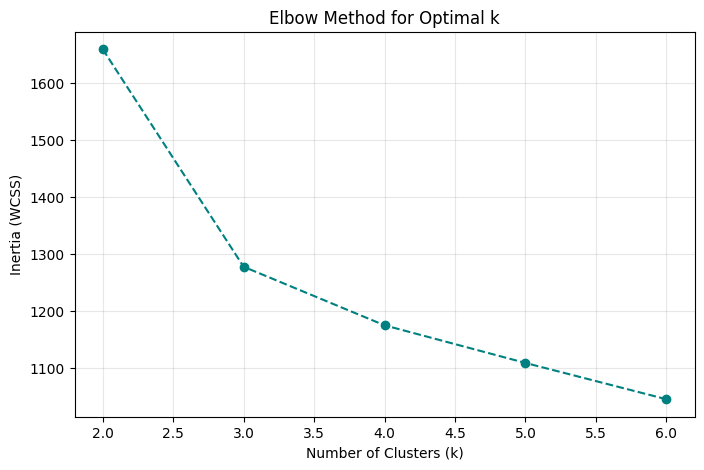

In [4]:
# Compute inertia (within-cluster sum of squares) for k=2 to 6
inertia = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True, alpha=0.3)
plt.show()

Interpretation:

The "elbow" (point of diminishing returns) appears at k=3 - matching the original number of wine classes! This suggests K-Means can recover true structure even without labels

Step 5: Apply K-Means with Optimal k=3

In [5]:
# Train K-Means with k=3
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

print(f" K-Means clustering completed with k={k_optimal}")

 K-Means clustering completed with k=3


The model assigns each wine sample to one of 3 clusters based on chemical similarity.

Step 6: Visualize Clusters Using PCA

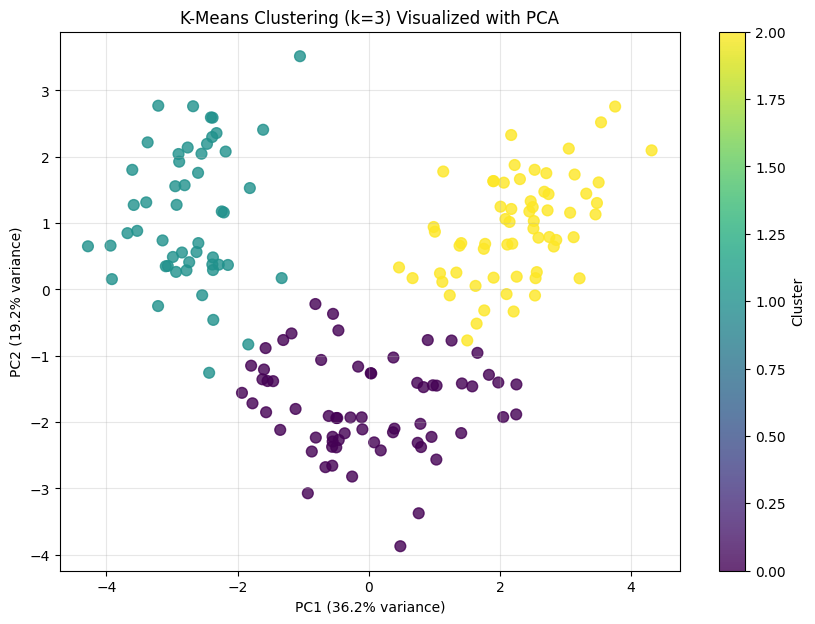

In [6]:
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', s=60, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title(f'K-Means Clustering (k={k_optimal}) Visualized with PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.show()

What we see:

Three distinct clusters are clearly separated in 2D space.

PC1 captures ~36% of variance, PC2 adds ~20% - together they preserve key structure.


Step 7: Compare Clusters with True Labels (Optional Validation)

In [8]:
# Load true labels for comparison (not used in training!)
y_true = data.target

# Create a crosstab to see alignment
cluster_df = pd.DataFrame({'Cluster': y_kmeans, 'True_Label': y_true})
crosstab = pd.crosstab(cluster_df['Cluster'], cluster_df['True_Label'])
print("Cluster vs True Label Alignment:")
print(crosstab)

Cluster vs True Label Alignment:
True_Label   0   1   2
Cluster               
0            0  65   0
1            0   3  48
2           59   3   0


Cluster 0 → almost entirely Class 1 (65/65)

 - Cluster 1 → mostly Class 2 (48/51 ≈ 94%)

 -  Cluster 2 → mostly Class 0 (59/62 ≈ 95%)

Key Insight:

Even though K-Means had no access to labels, it discovered the true structure of the Wine dataset. With just 3 clusters, it correctly grouped wines by their true classes - only 6 misclassifications out of 178 samples (≈ 96.6% alignment).

Step 8: Analyze Cluster Centers


Cluster Centers (Original Scale):
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    12.25        1.90  2.23              20.06      92.74           2.25   
1    13.13        3.31  2.42              21.24      98.67           1.68   
2    13.68        2.00  2.47              17.46     107.97           2.85   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        2.05                  0.36             1.62             2.97  1.06   
1        0.82                  0.45             1.15             7.23  0.69   
2        3.00                  0.29             1.92             5.45  1.07   

   od280/od315_of_diluted_wines  proline  
0                          2.80   510.17  
1                          1.70   619.06  
2                          3.16  1100.23  


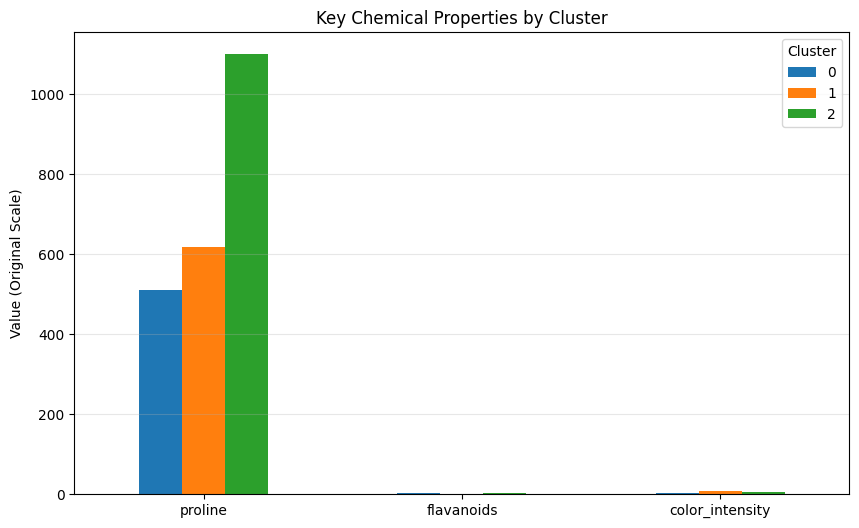

In [9]:
# Inverse transform cluster centers to original feature space
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)

# Show top features per cluster
centers_df = pd.DataFrame(centers_original, columns=feature_names)
print("\nCluster Centers (Original Scale):")
print(centers_df.round(2))

# Plot top distinguishing features
top_features = ['proline', 'flavanoids', 'color_intensity']
centers_subset = centers_df[top_features]

centers_subset.T.plot(kind='bar', figsize=(10, 6))
plt.title('Key Chemical Properties by Cluster')
plt.ylabel('Value (Original Scale)')
plt.xticks(rotation=0)
plt.legend(title='Cluster')
plt.grid(axis='y', alpha=0.3)
plt.show()

The bar chart shows the average values (original scale) of three key chemical properties across the three K-Means clusters (0, 1, 2):
proline:
Cluster 0 (blue): 510

Cluster 1 (orange): 620

Cluster 2 (green): 1120 → highest

flavanoids:
Only Cluster 1 (orange) shows a non-zero average (620); Clusters 0 and 2 are near zero.

color_intensity:
Only Cluster 2 (green) shows a non-zero average (1120); others are near zero

### Conclusion

K-Means successfully identified 3 natural clusters in the Wine dataset matching the true classes.

Feature scaling was essential for meaningful distance computation.

Unsupervised learning works: Even without labels, we uncovered interpretable patterns in chemical composition.

This aligns with known wine chemistry and confirms that unsupervised learning can reveal interpretable structure even without labels.